In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import numpy as np
import torch
from typing import Optional
from scipy.optimize import linear_sum_assignment


def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
    """
    Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
    determine reassignments.
    :param y_true: list of true cluster numbers, an integer array 0-indexed
    :param y_predicted: list  of predicted cluster numbers, an integer array 0-indexed
    :param cluster_number: number of clusters, if None then calculated from input
    :return: reassignment dictionary, clustering accuracy
    """
    if cluster_number is None:
        cluster_number = (
            max(y_predicted.max(), y_true.max()) + 1
        )  # assume labels are 0-indexed
    count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
    for i in range(y_predicted.size):
        count_matrix[y_predicted[i], y_true[i]] += 1

    row_ind, col_ind = linear_sum_assignment(count_matrix.max() - count_matrix)
    reassignment = dict(zip(row_ind, col_ind))
    accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
    return reassignment, accuracy

In [3]:
def lp_distance(X, Y, p=1):
    """
    Computes row wise minkowski distances between matrices X and Y
    """
    return torch.sum(torch.abs(X-Y)**p, dim=1)**(1/p)

In [4]:
from transformers import PreTrainedTokenizer
from typing import *

def mask_tokens(inputs: torch.Tensor, tokenizer) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
    """

    if tokenizer.mask_token is None:
        raise ValueError(
            "This tokenizer does not have a mask token which is necessary for masked language modeling. Remove the --mlm flag if you want to use this tokenizer."
        )

    labels = inputs.clone()
    # We sample a few tokens in each sequence for masked-LM training (with probability args.mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, 0.15)
    special_tokens_mask = [
        tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
    ]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)
    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [5]:
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, texts, labels):
        
        self.texts = texts
        self.labels = labels


        self.labels = torch.tensor(self.labels, dtype=torch.float)
        
    def __getitem__(self, index):
        return self.texts[index], self.labels[index]

    
    def __len__(self):
        return len(self.texts)

In [6]:
# 20 newsgroups
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(
    categories=['comp.graphics', 'talk.religion.misc', 'rec.autos', 'misc.forsale'],
    remove=('headers', 'footers', 'quotes'),
    shuffle=True,
    random_state=42
)
texts, labels = data.data, data.target

<BarContainer object of 4 artists>

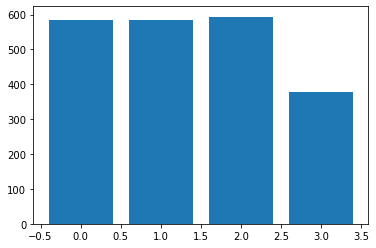

In [7]:
plt.bar(*np.unique(labels, return_counts=True))

In [8]:
#imdb_reviews
#import tensorflow_datasets as tfds
#from itertools import chain
#
#train_ds = tfds.load('imdb_reviews', split='train', shuffle_files=True)
#test_ds = tfds.load('imdb_reviews', split='test', shuffle_files=True)
#
#texts, labels = [], []
#
#for ds in (train_ds, test_ds):
#    for example in tfds.as_numpy(ds):
#        text, label = example['text'], example['label']
#        texts.append(str(text))
#        labels.append(label)
#
#labels = np.array(labels)

In [9]:
from sklearn.model_selection import train_test_split

texts, _, labels, _ = train_test_split(texts, labels, test_size=0.9, random_state=42)

In [10]:
data = TextDataset(texts, labels)
data_loader = DataLoader(dataset=data, batch_size=8, shuffle=False)

In [11]:
from transformers import DistilBertTokenizer, DistilBertForMaskedLM
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model = DistilBertForMaskedLM.from_pretrained('distilbert-base-uncased', return_dict=True)
lm_model.to('cuda')

DistilBertForMaskedLM(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): L

In [12]:
from tqdm import tqdm
embeddings = []
for index, text in tqdm(enumerate(texts)):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    inputs = inputs.to('cuda')
    outputs = lm_model.base_model(**inputs)
    cls_embedding = outputs.last_hidden_state[:,0,:].flatten().cpu().detach().numpy() # 
    embeddings.append(cls_embedding)
embeddings = np.array(embeddings)

214it [00:01, 108.34it/s]


In [13]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(labels).shape[0], n_init=20)

kmeans_cluster = kmeans.fit_predict(embeddings)
kmean_centroids = torch.from_numpy(kmeans.cluster_centers_)
kmean_centroids = kmean_centroids.to('cuda')

In [14]:
from umap import UMAP

umap = UMAP(n_components=2)
embeddings_plot = umap.fit_transform(embeddings)

/home/keller/.conda/envs/cuda/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10006. The TBB threading layer is disabled.
  warnings.warn(problem)


In [15]:
import plotly.express as px
fig = px.scatter(x=embeddings_plot[:, 0], y=embeddings_plot[:, 1], color=[f'{i}' for i in kmeans_cluster])
fig.show()

In [16]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score

print(cluster_accuracy(labels, kmeans_cluster)[1])
print(normalized_mutual_info_score(labels, kmeans_cluster))
print(adjusted_rand_score(labels, kmeans_cluster))
print(silhouette_score(embeddings, kmeans_cluster, metric="cosine"))

0.5934579439252337
0.3876039493862194
0.3575747478276824
0.20377389


In [17]:
import random
initial_centroids = np.array([embeddings[i] for i in (random.randint(0, embeddings.shape[0]-1) for _ in range(np.unique(labels).shape[0]))])
initial_centroids = torch.from_numpy(initial_centroids).to('cuda')
initial_centroids

tensor([[-0.1565, -0.0992,  0.1569,  ..., -0.1375,  0.2385,  0.4614],
        [ 0.1812,  0.0661, -0.0190,  ..., -0.0803,  0.3992,  0.2664],
        [-0.1305, -0.0583, -0.0564,  ..., -0.1549,  0.3689,  0.3085],
        [-0.4128, -0.2159,  0.0336,  ..., -0.0054,  0.3439,  0.4171]],
       device='cuda:0')

Epoch 0 (Alpha -0.0) | Batch: 26 | Combined Loss: 10.23706778655472 | Clustering Loss: 91.56134779652407 | LM Loss 2.829500198364258 | Accuracy 0.6666666666666666: : 27it [00:08,  3.22it/s]


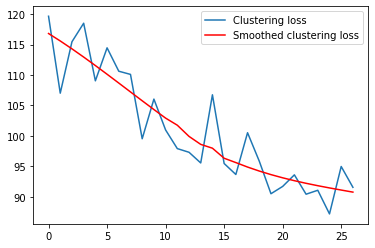

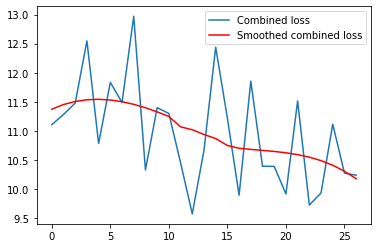

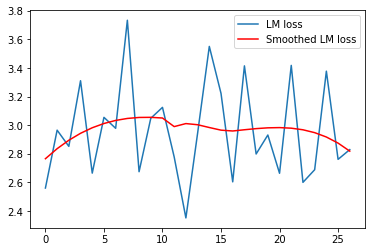

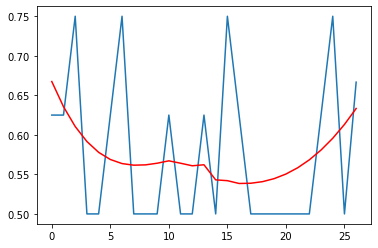

Epoch 1 (Alpha -0.5555555555555556) | Batch: 26 | Combined Loss: 8.414795002277138 | Clustering Loss: 76.52798813453201 | LM Loss 2.2941977977752686 | Accuracy 0.8333333333333334: : 27it [00:08,  3.21it/s]


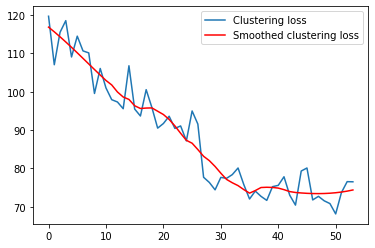

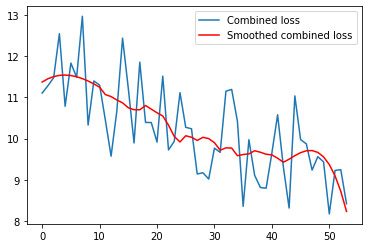

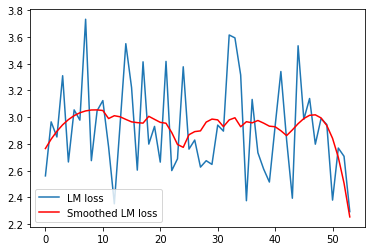

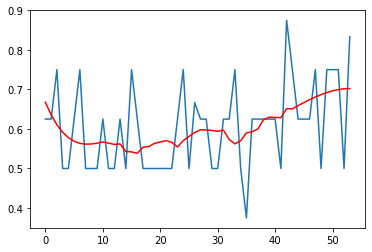

Epoch 2 (Alpha -1.1111111111111112) | Batch: 26 | Combined Loss: 8.984391025216157 | Clustering Loss: 73.04620368303407 | LM Loss 2.6660404205322266 | Accuracy 0.8333333333333334: : 27it [00:08,  3.22it/s]


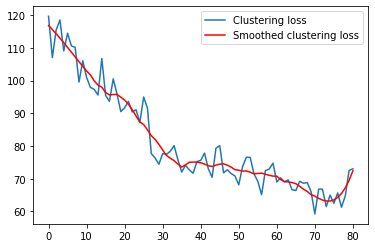

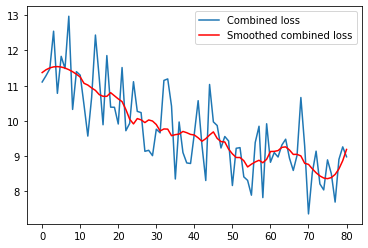

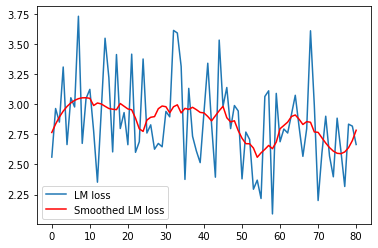

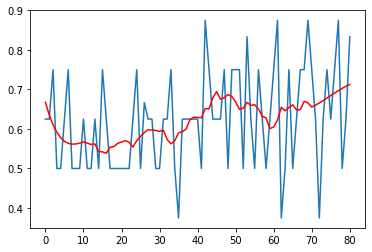

Epoch 3 (Alpha -1.6666666666666667) | Batch: 26 | Combined Loss: 8.832017093565572 | Clustering Loss: 67.51920043759563 | LM Loss 2.7280285358428955 | Accuracy 0.8333333333333334: : 27it [00:08,  3.20it/s]


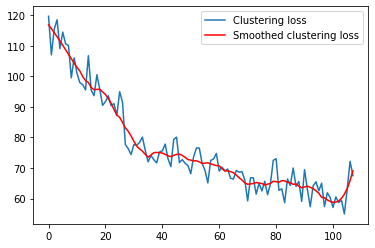

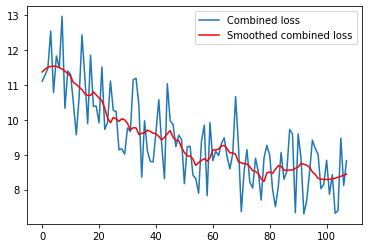

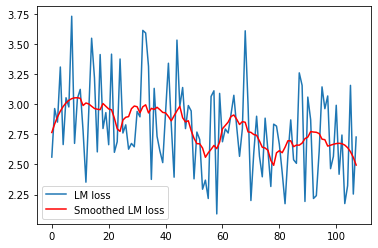

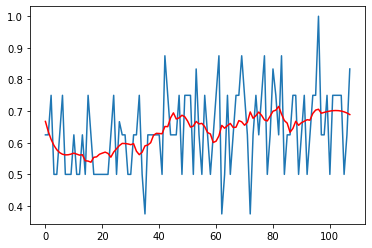

Epoch 4 (Alpha -2.2222222222222223) | Batch: 26 | Combined Loss: 8.00139668293799 | Clustering Loss: 63.203239978950236 | LM Loss 2.4206173419952393 | Accuracy 0.8333333333333334: : 27it [00:08,  3.15it/s]


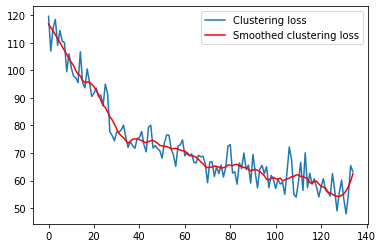

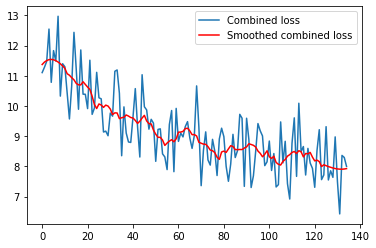

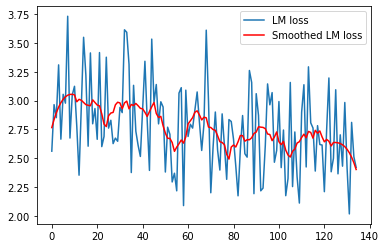

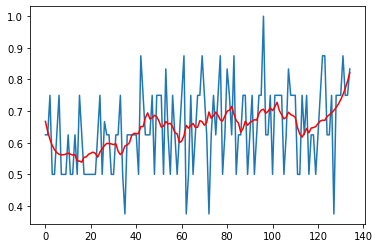

Epoch 5 (Alpha -2.7777777777777777) | Batch: 26 | Combined Loss: 7.988603240357534 | Clustering Loss: 60.270226123068646 | LM Loss 2.487545967102051 | Accuracy 0.6666666666666666: : 27it [00:08,  3.12it/s]


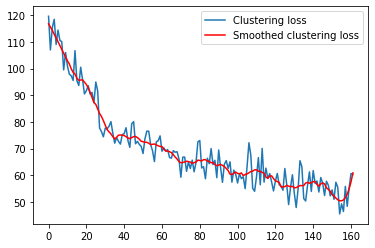

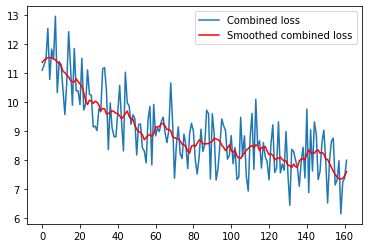

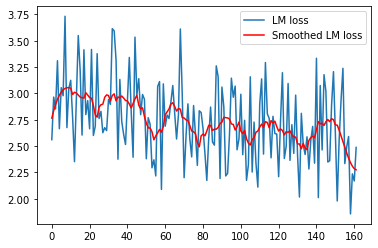

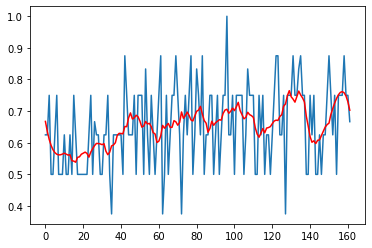

Epoch 6 (Alpha -3.3333333333333335) | Batch: 26 | Combined Loss: 7.29088205296066 | Clustering Loss: 54.450320044808905 | LM Loss 2.2841830253601074 | Accuracy 0.6666666666666666: : 27it [00:08,  3.09it/s]


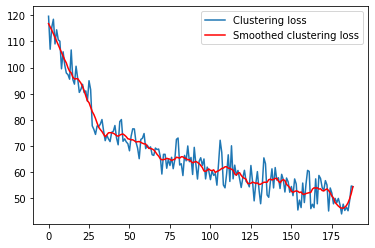

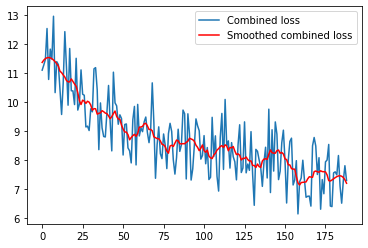

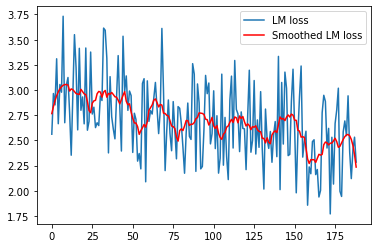

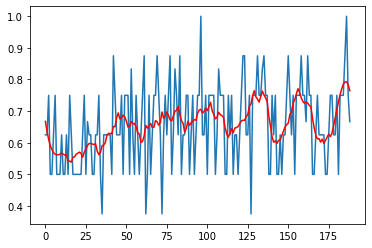

Epoch 7 (Alpha -3.8888888888888893) | Batch: 26 | Combined Loss: 7.336453091297161 | Clustering Loss: 53.90294335670492 | LM Loss 2.320652961730957 | Accuracy 0.6666666666666666: : 27it [00:08,  3.18it/s]


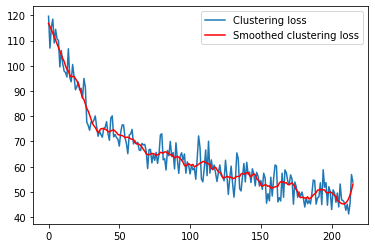

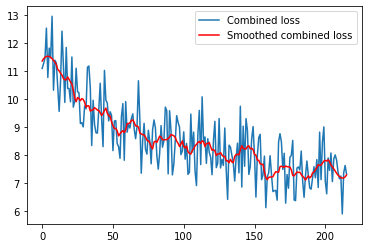

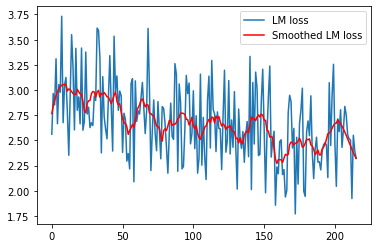

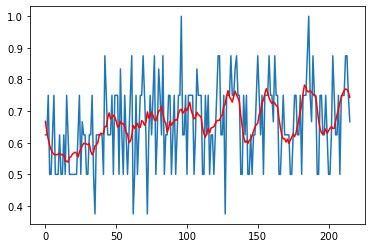

Epoch 8 (Alpha -4.444444444444445) | Batch: 26 | Combined Loss: 7.549830650950068 | Clustering Loss: 49.10421799947011 | LM Loss 2.5473098754882812 | Accuracy 0.6666666666666666: : 27it [00:08,  3.18it/s]


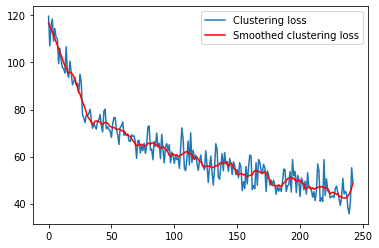

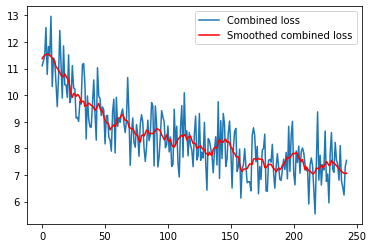

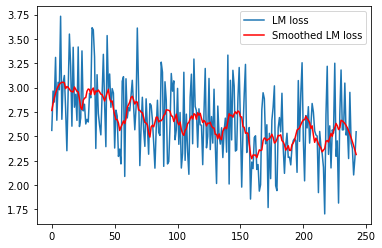

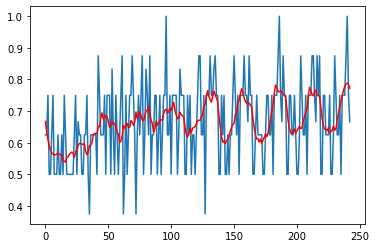

Epoch 9 (Alpha -5.0) | Batch: 26 | Combined Loss: 7.498061536353914 | Clustering Loss: 46.49757144057924 | LM Loss 2.5865914821624756 | Accuracy 0.6666666666666666: : 27it [00:08,  3.13it/s]


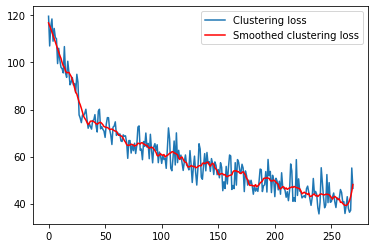

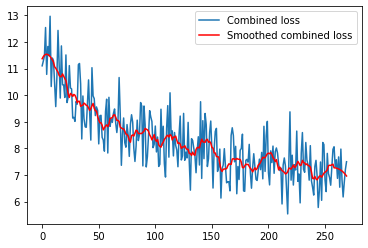

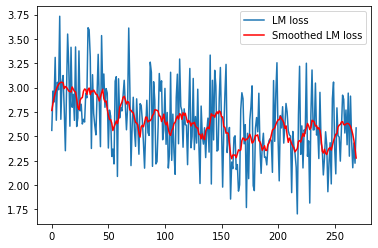

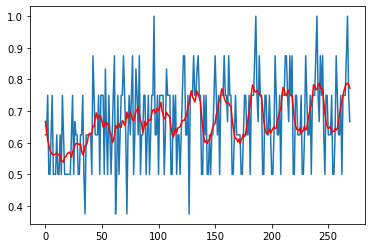

In [18]:
from scipy.signal import savgol_filter

centroids = initial_centroids.clone().to('cuda').requires_grad_(True)
#centroids = torch.Tensor(4, 768).uniform_(-10, 10).to(torch.float64).to('cuda').requires_grad_(True)
#centroids = kmean_centroids.clone().to('cuda').requires_grad_(True)  # go this way (cluster hardening)

#opt = torch.optim.SGD(params=[centroids] + list(lm_model.parameters()), lr=0.001)
opt = torch.optim.AdamW(params=[centroids] + list(lm_model.parameters()), lr = 2e-5, eps = 1e-8 )

lm_model.train()

comb_losses = []
clustering_losses = []
lm_losses = []
c_hist = []
emb_hist = []
acc = []

n_epochs = 10
annealing_alpha = np.linspace(0, 5, n_epochs)
alpha = 5.0
for epoch, alpha in zip(range(10), annealing_alpha):
    
    predicted_labels = []
    true_labels = []
    embs = []
    t = [] # improve this asap!

    c_hist.append(centroids.clone().detach().cpu().numpy())
    pbar = tqdm(enumerate(data_loader))
    for batch, batch_data in pbar:
        # lm part 
        texts, batch_labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        t.extend(texts)
        #inputs = inputs.to('cuda') # due to lm loss
        
        true_labels.extend(batch_labels)
        
        
        # clustering part
        input_ids = inputs['input_ids'].clone()
        input_ids, labels = mask_tokens(input_ids, tokenizer)
        inputs['input_ids'] = input_ids

        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        outputs = lm_model(labels=labels, **inputs)
        lm_loss = outputs.loss
        
        
        texts, batch_labels = batch_data
        inputs = tokenizer(
                    texts,
                    return_tensors='pt',
                    padding=True,
                    truncation=True)
        inputs.to('cuda')
        
        # 0. obtain embeddings for each input
        input_embeddings = lm_model.base_model(**inputs).last_hidden_state[:,0,:]
        input_embeddings = input_embeddings.to(torch.float64)
        
        embs.append(input_embeddings.clone().cpu().detach().numpy())

        distances = torch.stack([lp_distance(embedding.unsqueeze(0), centroids) for embedding in input_embeddings])
        #nearest_centroids = torch.argmin(distances, dim=1).cpu().clone().detach()
        nearest_centroids = torch.argmin(distances.cpu().clone().detach(), dim=1)
        distances = torch.transpose(distances, 0, 1)    

        # => shape (n_centroids, n_samples)
        # 2. compute the softmax for each centroid of each distance to each centroid per input sample
        # find min distances for each centroid
        min_distances = torch.min(distances, dim=1).values
        exponentials = torch.exp(- alpha * (distances - min_distances.unsqueeze(1)))
        softmax = exponentials / torch.sum(exponentials, dim=1).unsqueeze(1)

        # 3. weight the distanace between each sample and each centroid
        weighted_distances = distances * softmax


        # 4. sum over centroids to obtain loss
        opt.zero_grad()
        
        clustering_loss = weighted_distances.sum(dim=1).mean()
        comb_loss = (lm_loss * 2.0) + (0.05 * clustering_loss)
        comb_loss.backward()

        opt.step()

        accuracy = cluster_accuracy(batch_labels.numpy().astype('int'), nearest_centroids.numpy().astype('int'))[1]
        acc.append(accuracy)
        predicted_labels.extend(nearest_centroids.numpy())
        clustering_losses.append(clustering_loss.item())
        lm_losses.append(lm_loss.item())
        comb_losses.append(comb_loss.item())
        
        pbar.set_description(f"Epoch {epoch} (Alpha -{alpha}) | Batch: {batch} | Combined Loss: {comb_loss.item()} | Clustering Loss: {clustering_loss.item()} | LM Loss {lm_loss.item()} | Accuracy {accuracy}")
        
        #print(centroids)
    emb_hist.append(embs)
    plt.plot(clustering_losses, label="Clustering loss")
    plt.plot(savgol_filter(clustering_losses, 21, 3), color='red', label="Smoothed clustering loss")
    plt.legend()
    plt.show()
    plt.plot(comb_losses, label="Combined loss")
    plt.plot(savgol_filter(comb_losses, 21, 3), color='red', label="Smoothed combined loss")
    plt.legend()
    plt.show()
    plt.plot(lm_losses, label="LM loss")
    plt.plot(savgol_filter(lm_losses, 21, 3), color='red', label="Smoothed LM loss")
    plt.legend()
    plt.show()
    plt.plot(acc, label="Batch Accuracy")
    plt.plot(savgol_filter(acc, 21, 3), color='red', label="Smoothed Batch Accuracy")
    plt.show()
    
    # eval part

In [19]:
np_centroids = centroids.cpu().detach().numpy()
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels).astype('int')
true_labels.shape, predicted_labels.shape

embs = np.vstack(embs)

In [20]:
print(cluster_accuracy(true_labels, predicted_labels))
print(normalized_mutual_info_score(true_labels, predicted_labels))
print(adjusted_rand_score(true_labels, predicted_labels))

({0: 0, 1: 3, 2: 2, 3: 1}, 0.6495327102803738)
0.37746947479947063
0.3213759782082429


In [21]:
np.unique(predicted_labels, return_counts=True)

(array([0, 1, 2, 3]), array([63, 64, 40, 47]))

In [22]:
np.unique(true_labels, return_counts=True)

(array([0, 1, 2, 3]), array([66, 50, 59, 39]))

In [23]:
np.unique(kmeans_cluster, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([79, 66, 59, 10]))

In [24]:
from umap import UMAP
from sklearn.decomposition import PCA
umap = UMAP(n_components=2, n_neighbors=5)
Xo = np.vstack([embs, np_centroids])
Xro = umap.fit_transform(Xo)
labels_co = np.concatenate([predicted_labels, [f"Centroid {i}" for i in range(centroids.shape[0])]])
label_kmeans = np.concatenate([kmeans_cluster, [f"Centroid {i}" for i in range(centroids.shape[0])]])

In [25]:
t = [" ".join(i.split()) for i in t]

In [26]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in labels_co], hover_name=t+["centroid"]*centroids.shape[0])
fig.show()

In [27]:
import plotly.express as px
fig = px.scatter(x=Xro[:, 0], y=Xro[:, 1], color=[f'{i}' for i in label_kmeans], hover_name=t+["centroid"]*centroids.shape[0])
fig.show()

In [28]:
(np.vstack(emb_hist[0]) == np.vstack(emb_hist[-1])).all()

False

In [29]:
np.vstack(emb_hist[0]) == np.vstack(emb_hist[-1])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [30]:
print(* np.array(t)[np.array(predicted_labels) == 0], sep="\n"+"#"*100+"\n\n")

Yes, there are serveral programs which can convert font files (eq the Borland fonts) to objects consisting of spheres, cones etc. I've used a program (forgot its name/place, but i can look for it) which converted these Borland fonts to three different raytracers. Vivid, POV and Polyray (which i like more (more flexibel/faster/use of expressions etc). The program has a lot nice features. So if interested give me a mail.
####################################################################################################

I am setting up a video-aid for a computer room for the teacher to share his display with the class. I have seen people using video projector, TV sets and large monitor to do presentations before. I am told that there are three ways to connect video projector: composite, Y/C & RGB. Can anyone explain to me the difference and their likely costs? Please reply to my INETNET E-mail account as well as posting in bulletin: u129008@sparc20.nuc.edu.tw I also like to know if ther

In [31]:
np.unique(predicted_labels)

array([0, 1, 2, 3])

In [32]:
np.unique(true_labels)

array([0, 1, 2, 3])

In [33]:
np.vstack(emb_hist[-1])

array([[-0.12980622, -0.09846278,  0.11498426, ..., -0.0536942 ,
         0.25894022,  0.45310068],
       [-0.16075192, -0.08387813,  0.09768149, ..., -0.01779642,
         0.29351354,  0.46413231],
       [-0.24504766, -0.19163032,  0.01855952, ..., -0.000623  ,
         0.41017419,  0.27211019],
       ...,
       [-0.03331786,  0.00342026,  0.07225989, ..., -0.0396767 ,
         0.08996785,  0.30728793],
       [-0.31083682, -0.23985128,  0.06458547, ..., -0.04794445,
         0.26821312,  0.4116208 ],
       [-0.27215323, -0.09406334,  0.15058511, ..., -0.15155044,
         0.06903633,  0.51210159]])

In [34]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=np.unique(true_labels).shape[0], n_init=20)

end_embeddings_kmeans_cluster = kmeans.fit_predict(np.vstack(emb_hist[4]))

In [35]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

print(cluster_accuracy(true_labels, end_embeddings_kmeans_cluster)[1])
print(normalized_mutual_info_score(true_labels, end_embeddings_kmeans_cluster))
print(adjusted_rand_score(true_labels, end_embeddings_kmeans_cluster))

0.49065420560747663
0.22300870197402595
0.19990746734428202


In [36]:
from sklearn.metrics import silhouette_score
silhouette_score(np.vstack(emb_hist[-1]), end_embeddings_kmeans_cluster, metric="cosine")

0.13033743949683987

In [37]:
from sklearn.metrics import silhouette_score
silhouette_score(np.vstack(emb_hist[-1]), predicted_labels, metric="cosine")

0.2670808690609463